# **MINIPROYECTO 1**
## *Redes Neuronales Artificiales y Deep Learning* 
##### Integrantes: Avila Rendon Alejandra, Osuna Piñero Carlos Álvaro, Patiño Gomez Angie Valentina, Ruiz Delgado Carlos Alberto 

### **Descripción del problema** 

La relación cuantitativa estructura-actividad (QSAR) es el proceso por el cual la estructura química se correlaciona cuantitativamente con un proceso bien definido, como la reactividad química. En este caso, se uso para predecir la toxicidad acuática aguda hacia los peces Pimephales Promelas (piscardo de cabeza gorda). 

#### Imports

In [101]:
# Python ≥3.5 es requerido
import sys
assert sys.version_info >= (3, 5)

# Remover los warnings con el proposito de que el notebook sea mas limpio
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# importaciones comunes
import numpy as np
import pandas as pd
import os
import json

# hacer semilla para que los resultados sean reproducibles
np.random.seed(42)
SEED = 42

try:
    # %tensorflow_version Indicar que se esta usando la version 2.x de Tensorflow
    # solo existe en Colab
    %tensorflow_version 2.x
except Exception:
    pass


# TensorFlow ≥2.0 es requerido

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # remover los warnings de tensorflow
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# cargar el modulo de Tensorboard
%load_ext tensorboard

# Scikit-Learn ≥0.20 es requerido
import sklearn
assert sklearn.__version__ >= "0.20"

# para hacer graficos
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("colorblind")
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# para guardar las figuras
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "QSAR_Fish_Toxicity"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
MODELS_PATH = os.path.join(PROJECT_ROOT_DIR, "models", CHAPTER_ID)
WEIGHTS_PATH = os.path.join(PROJECT_ROOT_DIR, "weights", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)
os.makedirs(WEIGHTS_PATH, exist_ok=True)


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
# función para guardar las figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Guardando figura", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


In [3]:
def get_run_logdir(): return os.path.join(
    PROJECT_ROOT_DIR,
    "logs",
    CHAPTER_ID
)

#### **Lectura del dataset desde un archivo excel**

Este dataset ofrece datos correspondiente a 908 muestras para predecir la toxicidad acuática aguda en peces de la especie Pimephales promelas en términos del LC50, definido como la concentración que causa la muerte al 50% de los peces de prueba en un análisis de 96 horas.

***Entradas:***

*   **CIC0:** Capacidad del intercambio catiónico de orden 0, inversamente proporcional a la cantidad de elementos químicos distintos presentes en una molécula.
*  **SM1_Dz(Z):** Momento espectral de orden 1 de la matriz de Barysz ponderada por número atómico y el orden del enlace.
*   **GATS1i:** Cuantifica la diferencia en el potencial de ionización entre dos átomos enlazados.
*   **NdsCH:** Número de átomos de tipo dsCH presentes.
*   **NdssC:** Número de átomos de tipo dssC presentes.
*   **MLOGP:** Relación de concentración de un soluto en octanol-agua.


***Salida:***

*   **LC50:** Concentración de una sustancia tóxica necesaria para matar al 50% de una población.

In [4]:
DATASET_FILE = "qsar_fish_toxicity.csv"
DATASET_FILE_PATH = os.path.join(PROJECT_ROOT_DIR, DATASET_FILE)
DATASET_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00504/qsar_fish_toxicity.csv"

In [5]:
# cargar el dataset local, en caso de no existir, descargarlo
if not os.path.isfile(DATASET_FILE_PATH):
    import urllib.request
    print("Descargando el dataset...")
    urllib.request.urlretrieve(DATASET_URL, DATASET_FILE_PATH)
    print("Dataset descargado")

In [6]:
# cargar el dataset en un dataframe
data = pd.read_csv(DATASET_FILE_PATH, delimiter=';', names=["CIC0","SM1_Dz(Z)","GATS1i","NdsCH","NdssC","MLOGP","LC50"]) 
print(data.shape)
data.head(10)

(908, 7)


CIC0  SM1_Dz(Z)  GATS1i  NdsCH  NdssC  MLOGP   LC50
0  3.260      0.829   1.676      0      1  1.453  3.770
1  2.189      0.580   0.863      0      0  1.348  3.115
2  2.125      0.638   0.831      0      0  1.348  3.531
3  3.027      0.331   1.472      1      0  1.807  3.510
4  2.094      0.827   0.860      0      0  1.886  5.390
5  3.222      0.331   2.177      0      0  0.706  1.819
6  3.179      0.000   1.063      0      0  2.942  3.947
7  3.000      0.000   0.938      1      0  2.851  3.513
8  2.620      0.499   0.990      0      0  2.942  4.402
9  2.834      0.134   0.950      0      0  1.591  3.021

#### Análisis del dataset

In [7]:
data.describe() #Muestra la información estadística de cada variable

CIC0   SM1_Dz(Z)      GATS1i       NdsCH       NdssC       MLOGP  \
count  908.000000  908.000000  908.000000  908.000000  908.000000  908.000000   
mean     2.898129    0.628468    1.293591    0.229075    0.485683    2.109285   
std      0.756088    0.428459    0.394303    0.605335    0.861279    1.433181   
min      0.667000    0.000000    0.396000    0.000000    0.000000   -2.884000   
25%      2.347000    0.223000    0.950750    0.000000    0.000000    1.209000   
50%      2.934000    0.570000    1.240500    0.000000    0.000000    2.127000   
75%      3.407000    0.892750    1.562250    0.000000    1.000000    3.105000   
max      5.926000    2.171000    2.920000    4.000000    6.000000    6.515000   

             LC50  
count  908.000000  
mean     4.064431  
std      1.455698  
min      0.053000  
25%      3.151750  
50%      3.987500  
75%      4.907500  
max      9.612000

#### Verificación valores nulos

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   CIC0       908 non-null    float64
 1   SM1_Dz(Z)  908 non-null    float64
 2   GATS1i     908 non-null    float64
 3   NdsCH      908 non-null    int64  
 4   NdssC      908 non-null    int64  
 5   MLOGP      908 non-null    float64
 6   LC50       908 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 49.8 KB


El dataframe cuenta con 7 columnas, que comprenden los tipos de datos flotantes y enteros. Se observa que no hay valores nulos en el dataset. El valor a predecir es `LC50`, esta será la variable de salida.

In [9]:
data.isnull().sum() 
#No hay valores nulos

CIC0         0
SM1_Dz(Z)    0
GATS1i       0
NdsCH        0
NdssC        0
MLOGP        0
LC50         0
dtype: int64

#### Histogramas

Guardando figura attribute_histogram_plots


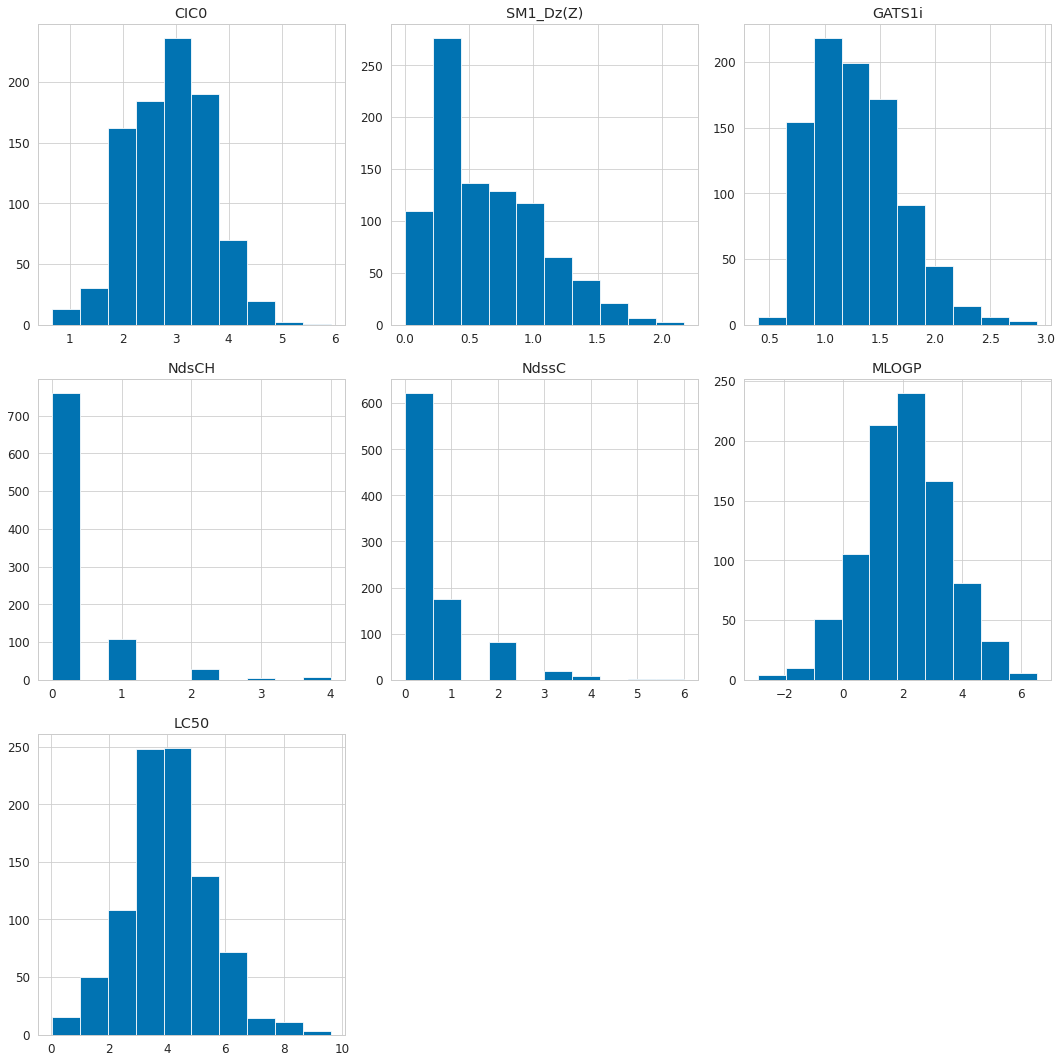

In [10]:
data.hist(figsize=(15,15))
save_fig("attribute_histogram_plots")
plt.show()

#### Matriz de correlación

In [11]:
corr =  data.corr()
print(corr)

               CIC0  SM1_Dz(Z)    GATS1i     NdsCH     NdssC     MLOGP  \
CIC0       1.000000  -0.235360  0.147622  0.121341  0.246639  0.463867   
SM1_Dz(Z) -0.235360   1.000000 -0.145967 -0.141401  0.163179  0.200663   
GATS1i     0.147622  -0.145967  1.000000 -0.010657  0.092410 -0.450739   
NdsCH      0.121341  -0.141401 -0.010657  1.000000  0.188164  0.048620   
NdssC      0.246639   0.163179  0.092410  0.188164  1.000000  0.028499   
MLOGP      0.463867   0.200663 -0.450739  0.048620  0.028499  1.000000   
LC50       0.291854   0.410893 -0.397965  0.172004  0.172390  0.651664   

               LC50  
CIC0       0.291854  
SM1_Dz(Z)  0.410893  
GATS1i    -0.397965  
NdsCH      0.172004  
NdssC      0.172390  
MLOGP      0.651664  
LC50       1.000000  


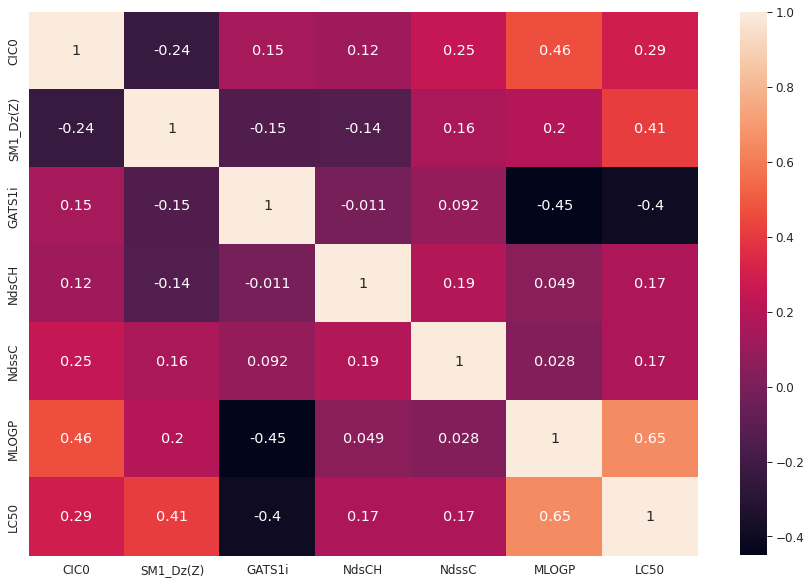

In [12]:
plt.figure(figsize=(15,10))
sns.heatmap(corr, annot=True)
plt.show()

#### Comportamiento de los datos con respecto a los demás

Guardando figura pairplot


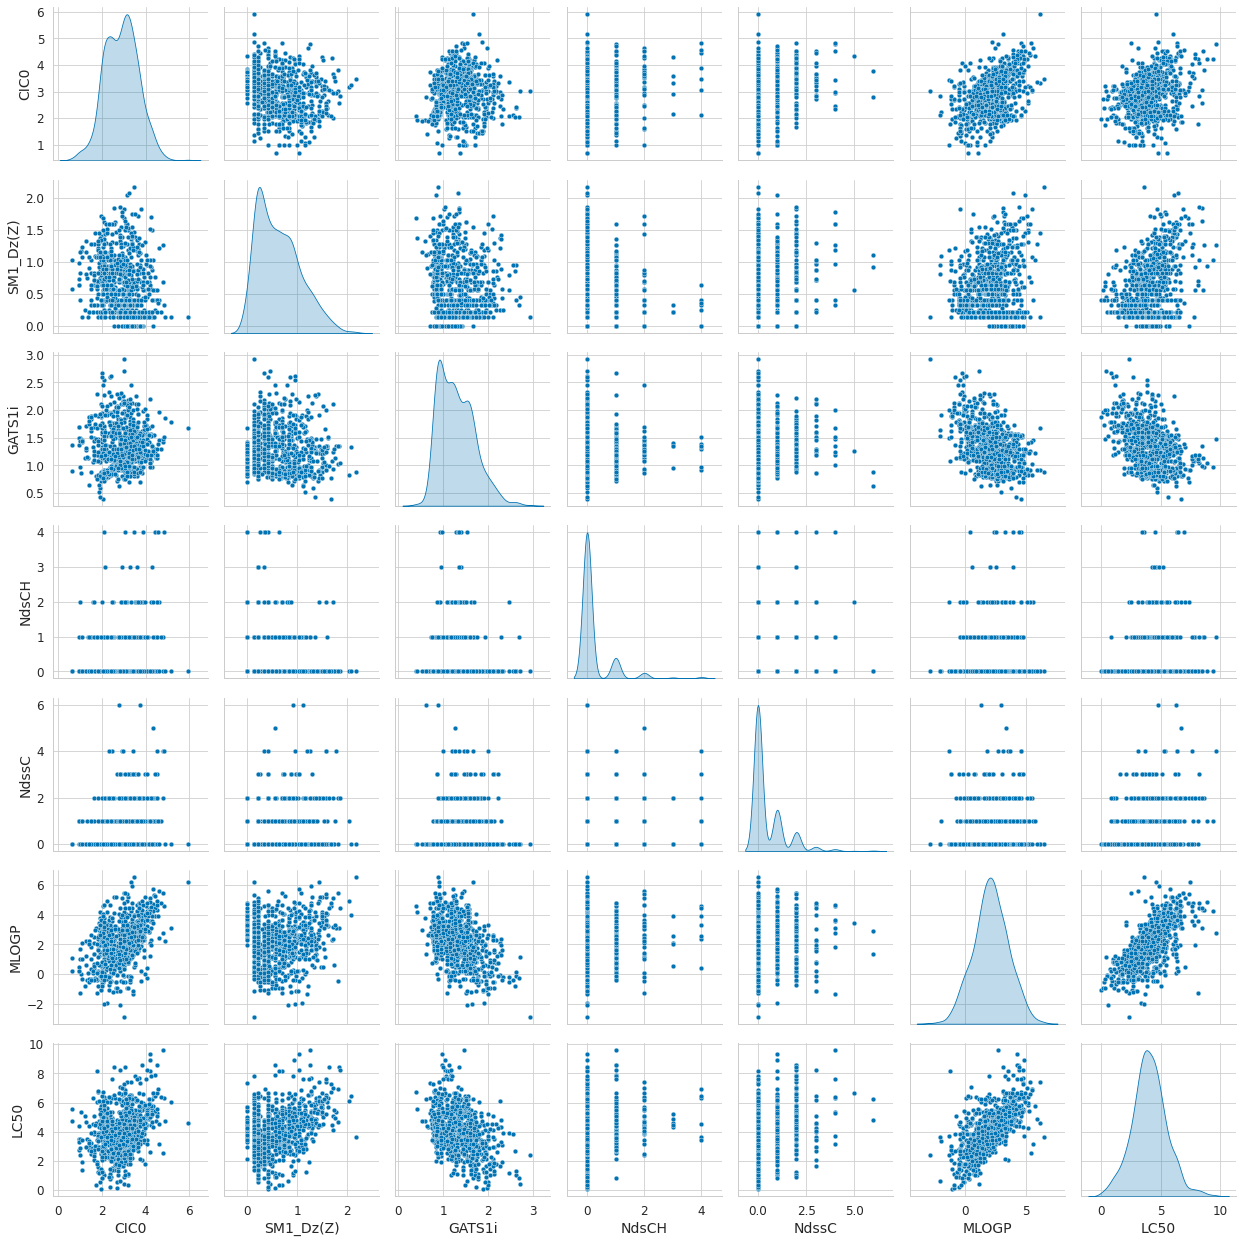

In [13]:
sns.pairplot(data, diag_kind="kde")
save_fig("pairplot")

#### Separar los datos de entrada del target

In [14]:
y = data['LC50']
X = data.drop(['LC50'], axis=1) #x_train

print(y.shape)
print(X.shape)

(908,)
(908, 6)


#### Normalización de los datos

> `MinMaxScaler` Transforma las funciones escalando cada función a un rango determinado.
> Este estimador escala y traduce cada característica individualmente de modo que esté en el rango dado en el conjunto de entrenamiento, por ejemplo, entre cero y uno. [Fuente](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [15]:
from sklearn.preprocessing import MinMaxScaler

# se aplica la normalización de los datos 
scaler = MinMaxScaler()
X_2 = scaler.fit_transform(X)
X_2 = pd.DataFrame(X_2, columns=X.columns)
X_2.head(10)


CIC0  SM1_Dz(Z)    GATS1i  NdsCH     NdssC     MLOGP
0  0.493060   0.381852  0.507132   0.00  0.166667  0.461432
1  0.289409   0.267158  0.185024   0.00  0.000000  0.450261
2  0.277239   0.293874  0.172345   0.00  0.000000  0.450261
3  0.448755   0.152464  0.426307   0.25  0.000000  0.499096
4  0.271344   0.380930  0.183835   0.00  0.000000  0.507501
5  0.485834   0.152464  0.705626   0.00  0.000000  0.381956
6  0.477657   0.000000  0.264263   0.00  0.000000  0.619853
7  0.443620   0.000000  0.214739   0.25  0.000000  0.610171
8  0.371363   0.229848  0.235341   0.00  0.000000  0.619853
9  0.412056   0.061723  0.219493   0.00  0.000000  0.476114

#### Feature Importance

> `Feature Importance` se refiere a las técnicas que calculan una puntuación para todas las características de entrada para un modelo dado; las puntuaciones simplemente representan la "importancia" de cada característica. Una puntuación más alta significa que la característica específica tendrá un mayor efecto en el modelo que se utiliza para predecir una determinada variable. [Terrence Shin](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285#:~:text=Feature%20Importance%20refers%20to%20techniques,to%20predict%20a%20certain%20variable.)


Guardando figura feature_importance


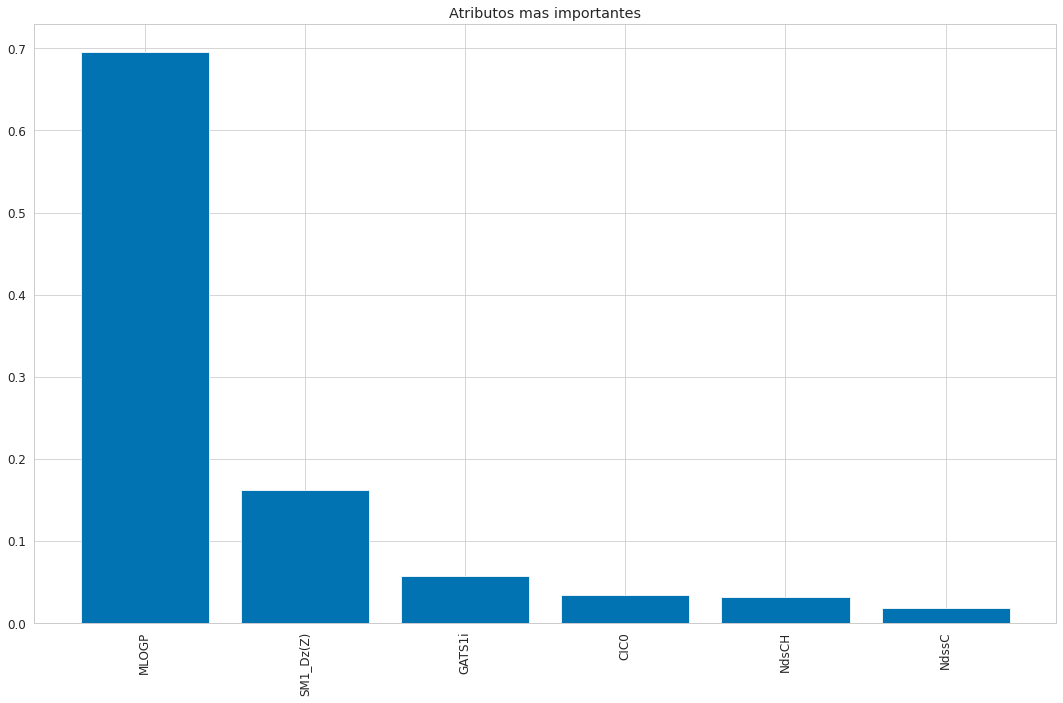

In [16]:
from sklearn.ensemble import RandomForestRegressor
# usamos un modelo de arbol de decisiones para obtener los atributos mas importantes
rf = RandomForestRegressor(n_estimators=100, max_depth=4, random_state=42)
rf.fit(X_2, y)

# obtener los atributos mas importantes
importances = rf.feature_importances_

# ordenar los atributos de mayor a menor importancia
indices = np.argsort(importances)[::-1]

# obtener los nombres de los atributos
names = [X.columns[i] for i in indices]

# graficar los atributos mas importantes
# escalar valor para que se vea mejor en la grafica
plt.figure(figsize=(15,10))
plt.title("Atributos mas importantes")
plt.bar(range(X_2.shape[1]), importances[indices])
plt.xticks(range(X_2.shape[1]), names, rotation=90)
save_fig("feature_importance")
plt.show()



In [17]:
for i in indices:
    print(f"{names[i]}: {importances[i]}")

NdssC: 0.6950209084635157
SM1_Dz(Z): 0.16282855271896482
GATS1i: 0.0569507084326903
MLOGP: 0.034423703750887276
CIC0: 0.0320348019411425
NdsCH: 0.018741324692799356


Los atributos más importantes según el procedimiento realizado son se mencionan en orden descendente:
- `NdssC`: `0.69501`
- `SM1_Dz(Z)`: `0.162676`
- `GATS1i`: `0.05684`
- `MLOGP`: `0.03448`
- `CIC0`: `0.0317984`
- `NdsCH`: `0.019186`

Esto da a entender que el atributo `NdssC` es el más importante para predecir el valor de `LC50`.

#### Separar datos de entrenamiento y validación

In [18]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_2, y.values, test_size=0.2, random_state=SEED)

print(f"La dimensión de la data de entrenamiento es: {X_train.shape}")
print(f"La dimensión de la data de prueba es: {X_test.shape}")
print(f"La dimensión de la data de salida de entrenamiento es: {y_train.shape}")
print(f"La dimensión de la data de salida de prueba es: {y_test.shape}")

La dimensión de la data de entrenamiento es: (726, 6)
La dimensión de la data de prueba es: (182, 6)
La dimensión de la data de salida de entrenamiento es: (726,)
La dimensión de la data de salida de prueba es: (182,)


#### Dimensión de Entrada y Número de Clases

In [19]:
INPUT_DIM = X_train.shape[1]
NUM_CLASSES = y_train.ndim

print(f"La dimensión de la data de entrada es: {INPUT_DIM}")
print(f"La dimensión de la data de salida es: {NUM_CLASSES}")

La dimensión de la data de entrada es: 6
La dimensión de la data de salida es: 1


#### Arquitectura del modelo

In [20]:
from tensorflow.keras.utils import plot_model

In [21]:
# función para graficar la pérdida
def graph_loss(history, name):
    plt.figure(figsize=(15,10))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    save_fig(name)
    plt.show()

In [22]:
# función para graficar la precisión
def graph_precision(history, name):
    plt.figure(figsize=(15,10))
    plt.plot(history.history['precision'], label='precision')
    plt.plot(history.history['val_precision'], label='val_precision')
    plt.xlabel('Epoch')
    plt.ylabel('precision')
    plt.legend()
    plt.grid(True)
    save_fig(name)
    plt.show()

In [23]:
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)
# función para evaluar el error cuadrado entre los valores reales y los predichos
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    score = model.evaluate(X_test,y_test,verbose=0)
    print(f"El error cuadrado medio es: {mse}")
    print(f"El error absoluto medio es: {mae}")
    print(f"El coeficiente de determinación es: {r2}")
    print(f"Score: {score}")

In [24]:
# función para graficar los valores reales y los predichos
def graph_real_vs_pred(y_test, y_pred, name):
    plt.figure(figsize=(15,10))
    plt.plot(y_test,'*r', label='real')
    plt.plot(y_pred,'.g', label='pred')
    plt.xlabel('Muestras')
    plt.ylabel('Valores')
    plt.legend()
    plt.grid(True)
    save_fig(name)
    plt.show()

In [25]:
from sklearn import linear_model
# función para graficar el coeficiente de regresión
def graph_coef(y_test, y_pred, name):
    target = y_test.reshape(y_test.shape[0], 1)

    regr = linear_model.LinearRegression()
    regr.fit(target, y_pred)

    coef = regr.coef_

    print(f"El coeficiente de regresión es: {coef}")

    plt.figure(figsize=(15,10))
    plt.plot(target, y_pred, '.-b', label='Coeficiente de regresión')
    save_fig(name)
    plt.show()

In [97]:
# función para guardar modelo
def save_model(model,name):
  model.save(
      os.path.join(
          MODELS_PATH,
          f"{name}.h5"
      )
  )

In [114]:
# función para guardar los pesos en un archivo json
def save_weights(model,name):
  file = os.path.join(
      WEIGHTS_PATH,
      f"{name}.json"
  )

  weights = model.get_weights()
  weights_list = []

  for i, weights in enumerate(weights):
    weights_list.append(weights.tolist())

  with open(file, 'w', encoding='utf-8') as f:
    json.dump(weights_list, f, ensure_ascii=False, indent=4)


**Arquitectua 1: 1 capa intermedia, 6 neuronas**

6 neuronas en la capa de entrada 6 neuronas en las capas ocultas 1 y 2 junto con la función de activación utilizada es RELU también 1 nodo en la salida porque este caso es regresión.

In [26]:
def get_model_1():
    model = keras.models.Sequential([
        keras.layers.Dense(6, activation="relu", input_shape=[INPUT_DIM]),
        keras.layers.Dense(6, activation="relu"),
        keras.layers.Dense(NUM_CLASSES, activation='linear')
    ])
    return model

_Hiperparámetros:_

| Hiperparámetro | Descripción                                                       | Valor               |
| :------------: | ----------------------------------------------------------------- | ------------------- |
|    `epochs`    | Número de iteraciones sobre el conjunto de datos de entrenamiento | 1000                 |
|  `batch_size`  | Número de muestras por gradiente                                  | 75                  |
|  `optimizer`   | Algoritmo de optimización                                         | Adam                |
|     `loss`     | Función de pérdida                                                | MSE                 |
|   `metrics`    | Métrica de evaluación                                             | MSE, MAE, Precision |


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6)                 42        
                                                                 
 dense_1 (Dense)             (None, 6)                 42        
                                                                 
 dense_2 (Dense)             (None, 1)                 7         
                                                                 
Total params: 91
Trainable params: 91
Non-trainable params: 0
_________________________________________________________________
None


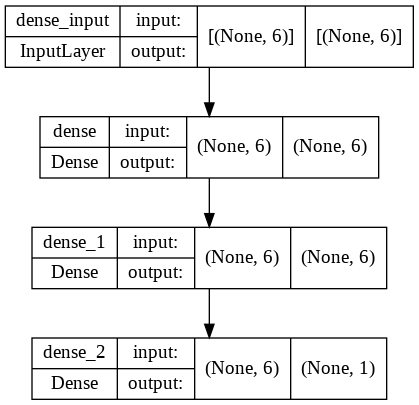

In [27]:
# Hiperparámetros Para el Modelo 1
# Utilizando el optimizador Adam
adam_optimizer = keras.optimizers.Adam(
    learning_rate=0.01
)

# Utilizando la función de pérdida MSE
mse_loss = keras.losses.MeanSquaredError()

# Utilizando la métrica MAE
mae_metric = keras.metrics.MeanAbsoluteError()

# Utilizando la métrica MSE
mse_metric = keras.metrics.MeanSquaredError()

# Utilizando el callback EarlyStopping y tensorboard
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Compilando el modelo
model_1 = get_model_1()
model_1.compile(
    loss=mse_loss, 
    optimizer=adam_optimizer,
    metrics=[mae_metric, mse_metric]
)

# mostrando el resumen del modelo
# guardando el esquema del modelo en un archivo
print(model_1.summary())
plot_model(model_1, to_file=os.path.join(IMAGES_PATH,'model_1.png'), show_shapes=True, show_layer_names=True)

In [28]:
# Entrenar el modelo
history = model_1.fit(
    X_train, 
    y_train,
    epochs=1000,
    callbacks=[tensorboard_cb,early_stopping_cb],
    validation_data=(X_test, y_test),
    batch_size=75,
    verbose=0
)

In [29]:
# Cargar Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Graficar la función de pérdida**

Guardando figura model_1_loss


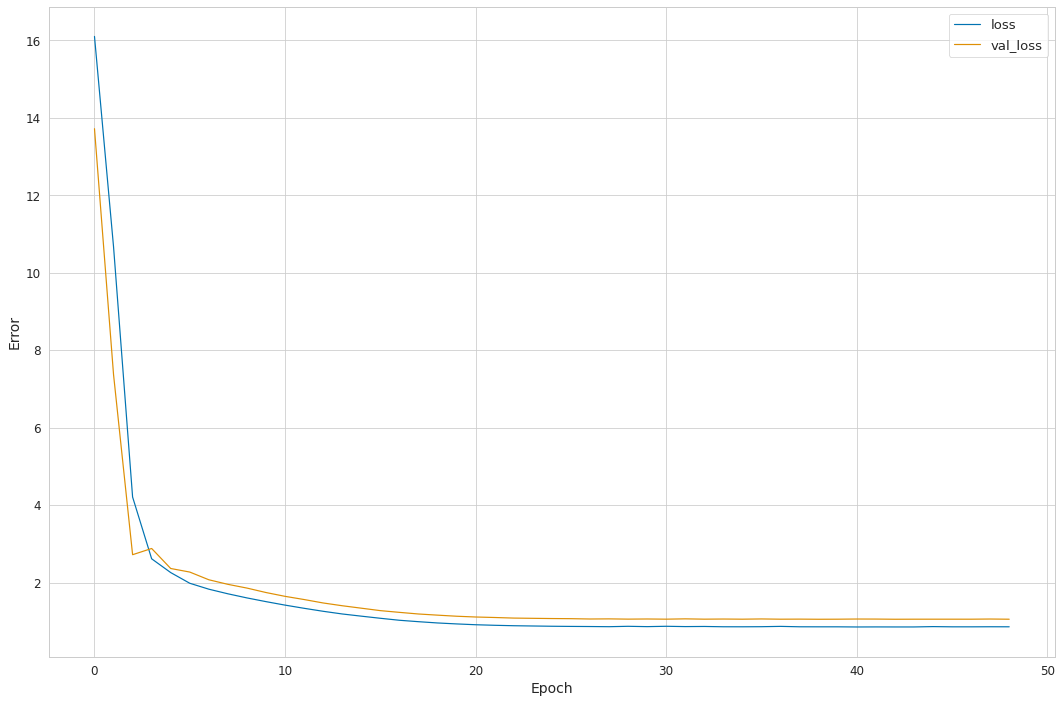

In [30]:
graph_loss(history, "model_1_loss")

**Evaluar el modelo**

In [31]:
evaluate_model(model_1, X_test, y_test)

El error cuadrado medio es: 1.0508208008332935
El error absoluto medio es: 0.7446738107283037
El coeficiente de determinación es: 0.5656824816810924
Score: [1.0508209466934204, 0.7446738481521606, 1.0508209466934204]


**Grafica de Valores Reales vs Predicciones**

Guardando figura model_1_real_vs_pred


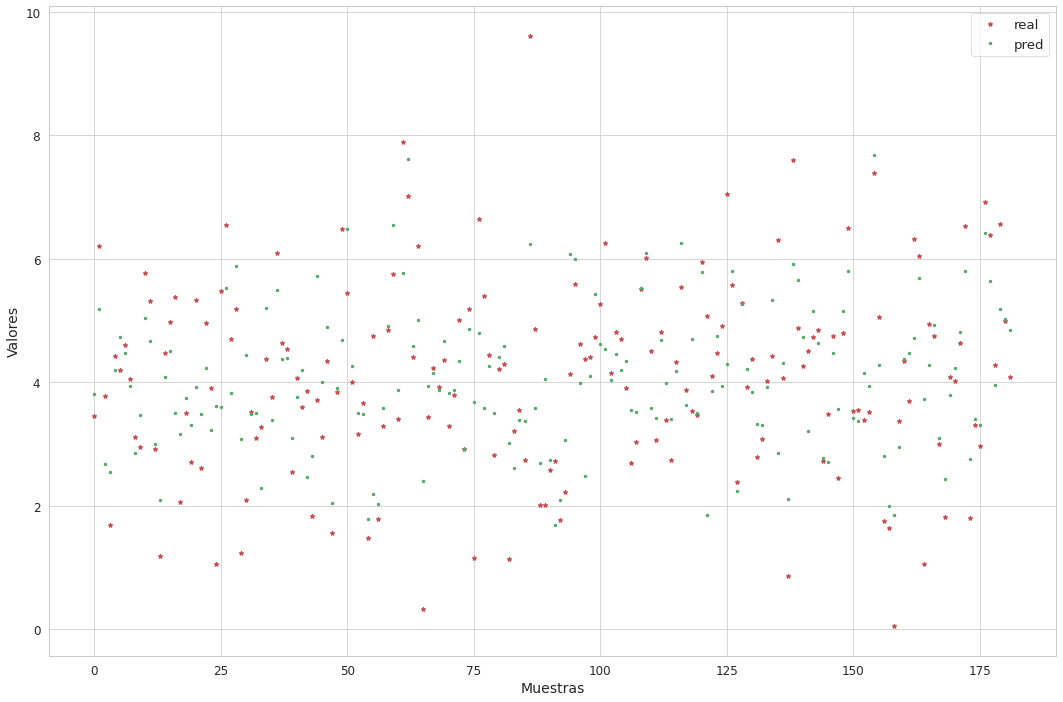

In [32]:
y_pred = model_1.predict(X_test)
graph_real_vs_pred(y_test, y_pred, "model_1_real_vs_pred")

Guardando figura model_1_real_vs_pred_train


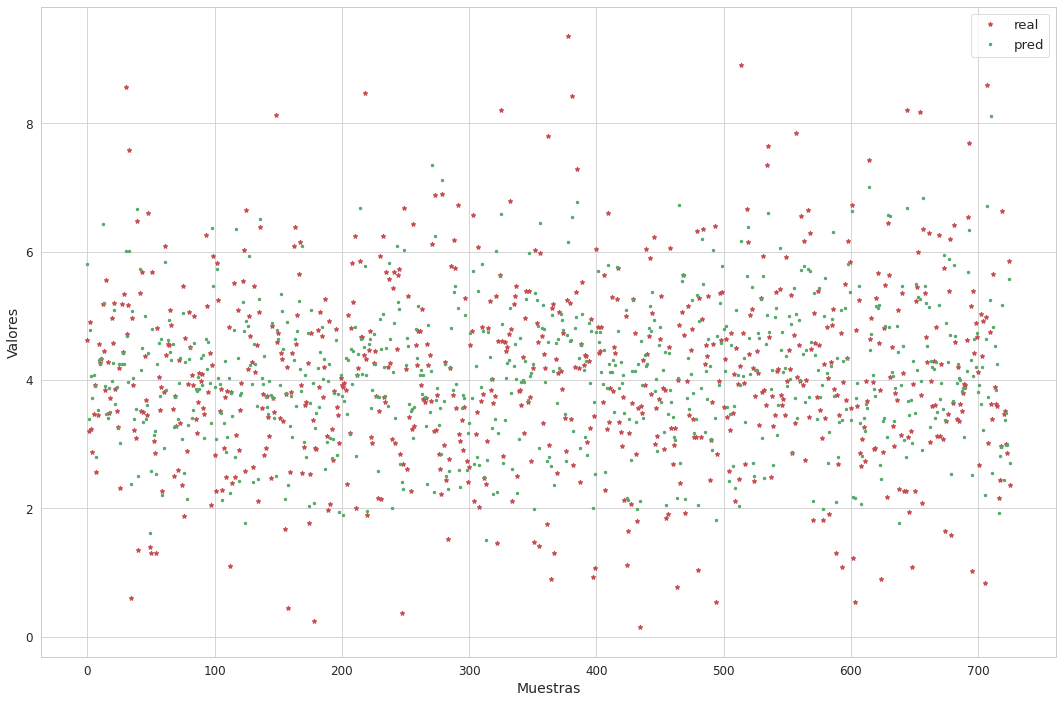

In [33]:
# con los datos de entrenamiento
y_pred = model_1.predict(X_train)
graph_real_vs_pred(y_train, y_pred, "model_1_real_vs_pred_train")

**Coeficiente de Regresión**

El coeficiente de predicción es: [[0.55291938]]
Guardando figura model_1_coef


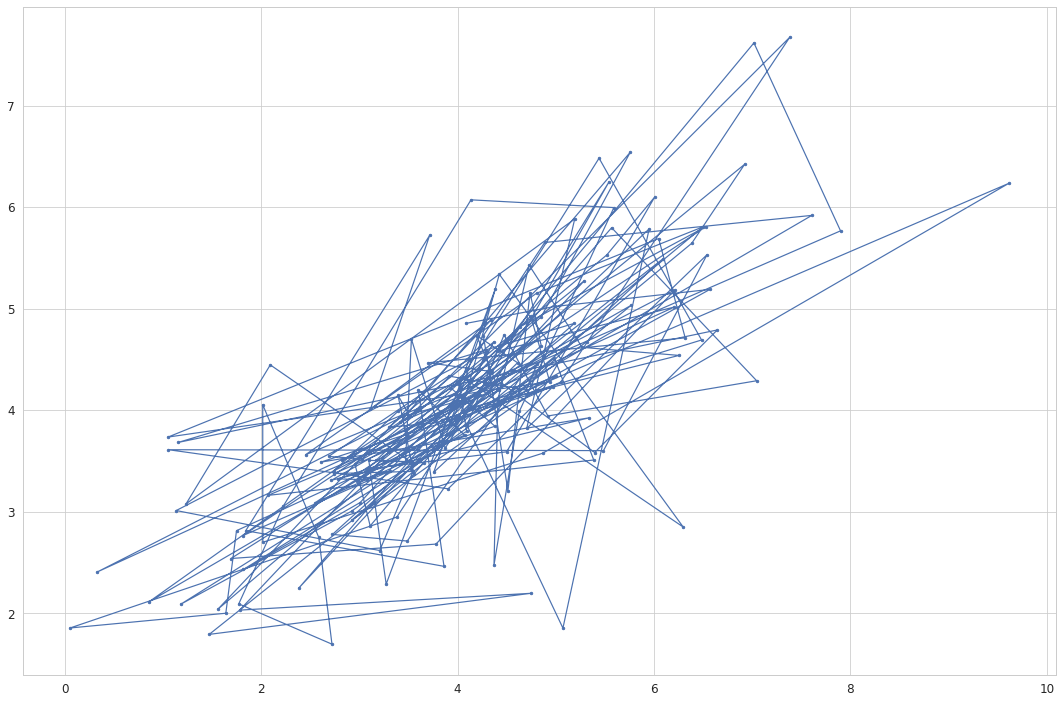

In [34]:
# con los datos de prueba
y_pred = model_1.predict(X_test)
graph_coef(y_test, y_pred, "model_1_coef")

El coeficiente de predicción es: [[0.57466554]]
Guardando figura model_1_coef_train


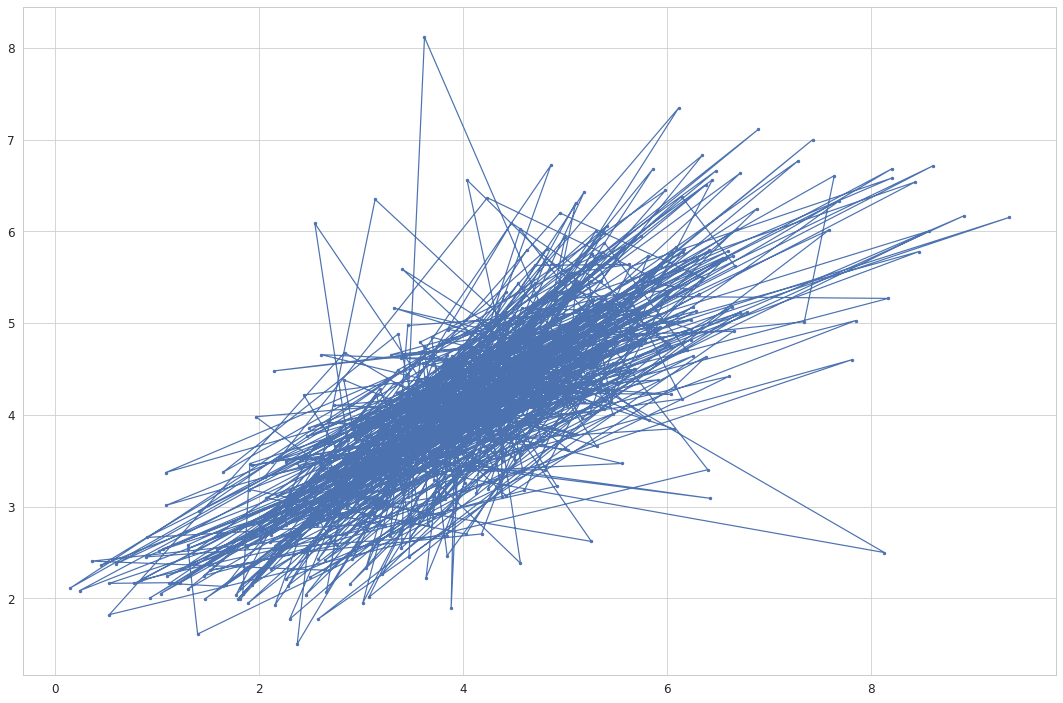

In [35]:
# predicción de los datos de entrenamiento
y_pred = model_1.predict(X_train)
graph_coef(y_train, y_pred, "model_1_coef_train")


**Arquitectura 2: 3 capas intermedias, 128 neuronas**

6 neuronas en la capa de entrada 128 neuronas en las capa oculta 1, 64 neuronas en la capa oculta 2, 64 neuronas en la capa oculta 2 junto con la función de activación utilizada es Sigmoid también 1 neurona en la salida.

In [36]:
def get_model_2():
    model = keras.models.Sequential([
        keras.layers.Dense(128, activation="sigmoid", input_shape=[INPUT_DIM]),
        keras.layers.Dense(64, activation="sigmoid"),
        keras.layers.Dense(64, activation="sigmoid"),
        keras.layers.Dense(NUM_CLASSES, activation="linear")
    ])
    return model

_Hiperparámetros:_

| Hiperparámetro | Descripción                                                       | Valor              |
| :------------: | ----------------------------------------------------------------- | ------------------ |
|    `epochs`    | Número de iteraciones sobre el conjunto de datos de entrenamiento | 900                |
|  `batch_size`  | Número de muestras por gradiente                                  | 32                 |
|  `optimizer`   | Algoritmo de optimización                                         | SGD with Momentum |
|     `loss`     | Función de pérdida                                                | MSE                |
|   `metrics`    | Métrica de evaluación                                             | MSE, MAE           |


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               896       
                                                                 
 dense_11 (Dense)            (None, 64)                8256      
                                                                 
 dense_12 (Dense)            (None, 64)                4160      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 13,377
Trainable params: 13,377
Non-trainable params: 0
_________________________________________________________________


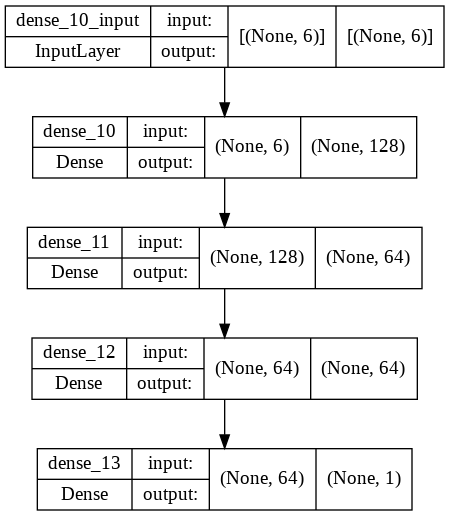

In [48]:
# Hiperparámetros Para el Modelo 1
# Utilizando el optimizador AdaGrad
sgd_optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True )

# Utilizando la función de pérdida MSE
mse_loss = keras.losses.MeanSquaredError()

# Utilizando la métrica MAE
mae_metric = keras.metrics.MeanAbsoluteError()

# Utilizando la métrica MSE
mse_metric = keras.metrics.MeanSquaredError()

# Utilizando el callback EarlyStopping y tensorboard
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Compilando el modelo
model_2 = get_model_2()
model_2.compile(
    loss=mse_loss, 
    optimizer=sgd_optimizer,
    metrics=[mae_metric, mse_metric]
)

# mostrando el resumen del modelo
# guardando el esquema del modelo en un archivo
model_2.summary()
plot_model(model_2, to_file=os.path.join(IMAGES_PATH,'model_2.png'), show_shapes=True, show_layer_names=True)

In [38]:
# Entrenar el modelo
history = model_2.fit(
    X_train, 
    y_train,
    epochs=5000,
    callbacks=[tensorboard_cb,early_stopping_cb],
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=0
)

In [39]:
# Cargar Tensorboard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


**Graficar la función de pérdida**

Guardando figura model_2_loss


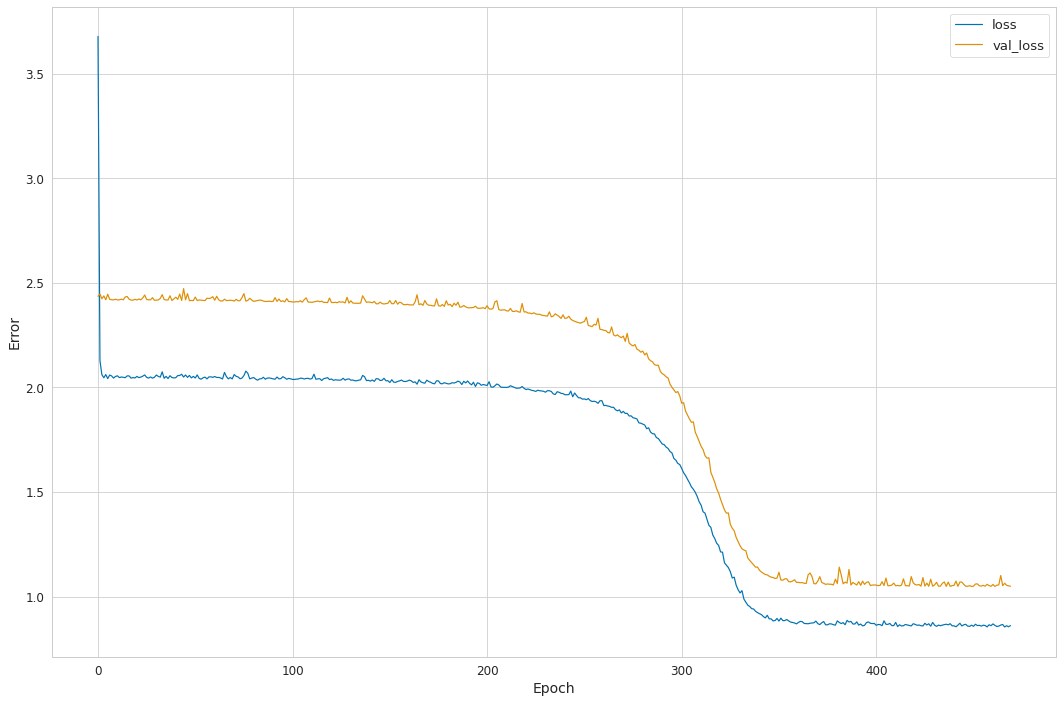

In [40]:
graph_loss(history, "model_2_loss")

**Evaluar el modelo**

In [41]:
evaluate_model(model_2, X_test, y_test)

El error cuadrado medio es: 1.0485462522522724
El error absoluto medio es: 0.7392441848450965
El coeficiente de determinación es: 0.5666225813576703
Score: [1.048546314239502, 0.7392441630363464, 1.048546314239502]


**Grafica de Valores Reales vs Predicciones**

Guardando figura model_2_real_vs_pred


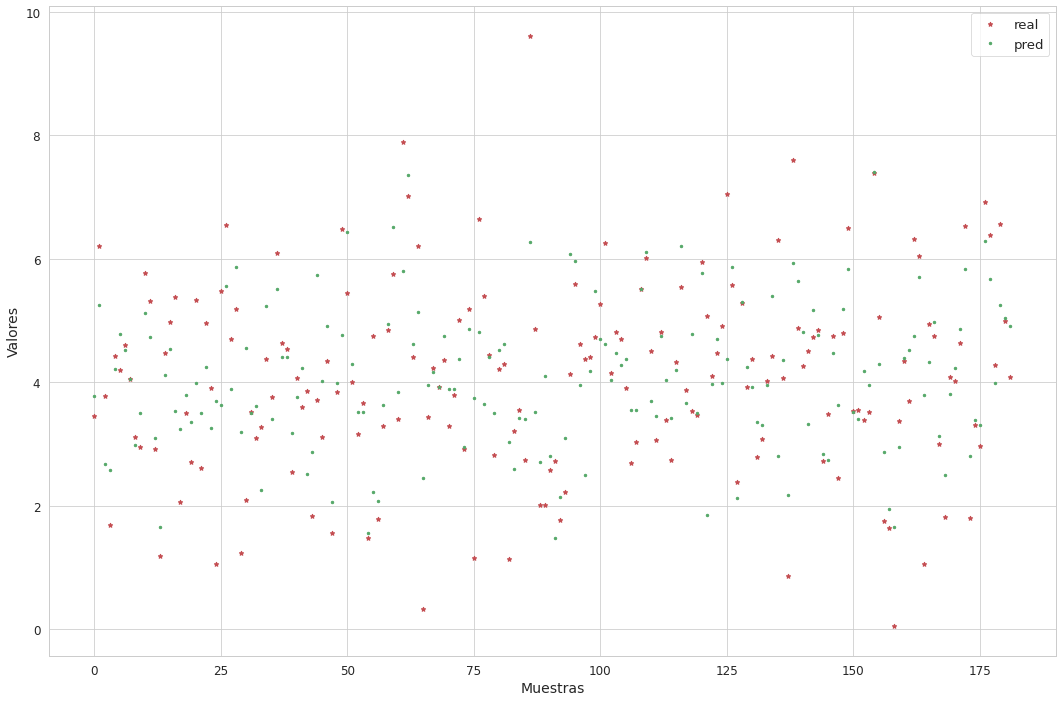

In [42]:
y_pred = model_2.predict(X_test)
graph_real_vs_pred(y_test, y_pred, "model_2_real_vs_pred")

Guardando figura model_2_real_vs_pred_train


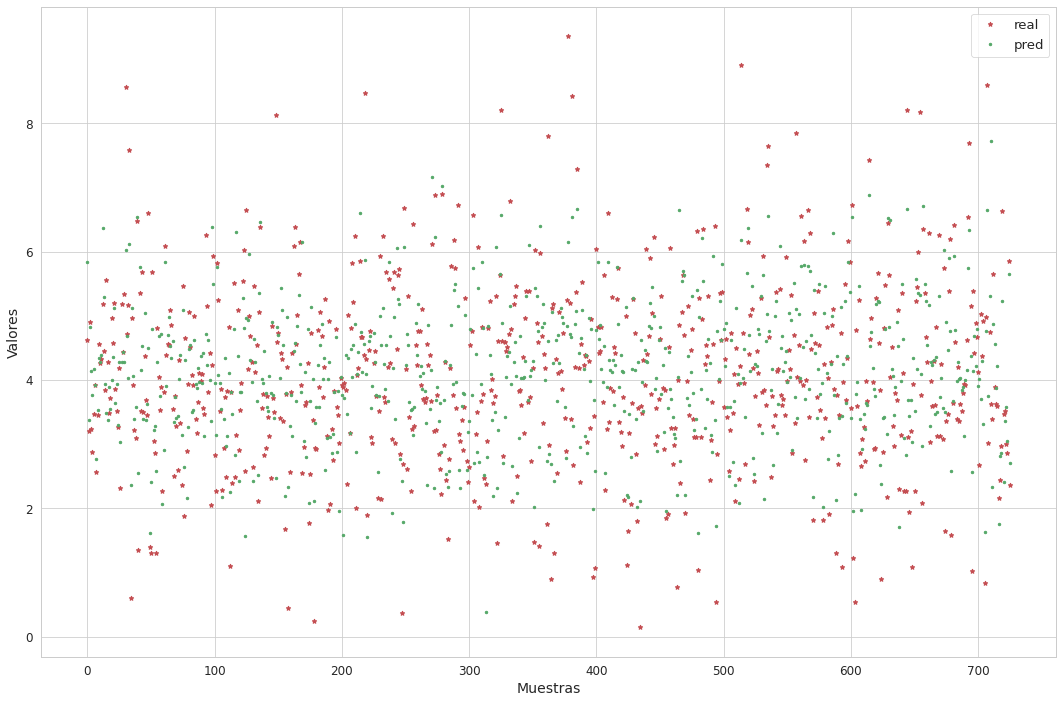

In [43]:
# con los datos de entrenamiento
y_pred = model_2.predict(X_train)
graph_real_vs_pred(y_train, y_pred, "model_2_real_vs_pred_train")

**Coeficiente de Regresión**

El coeficiente de predicción es: [[0.55386339]]
Guardando figura model_2_coef


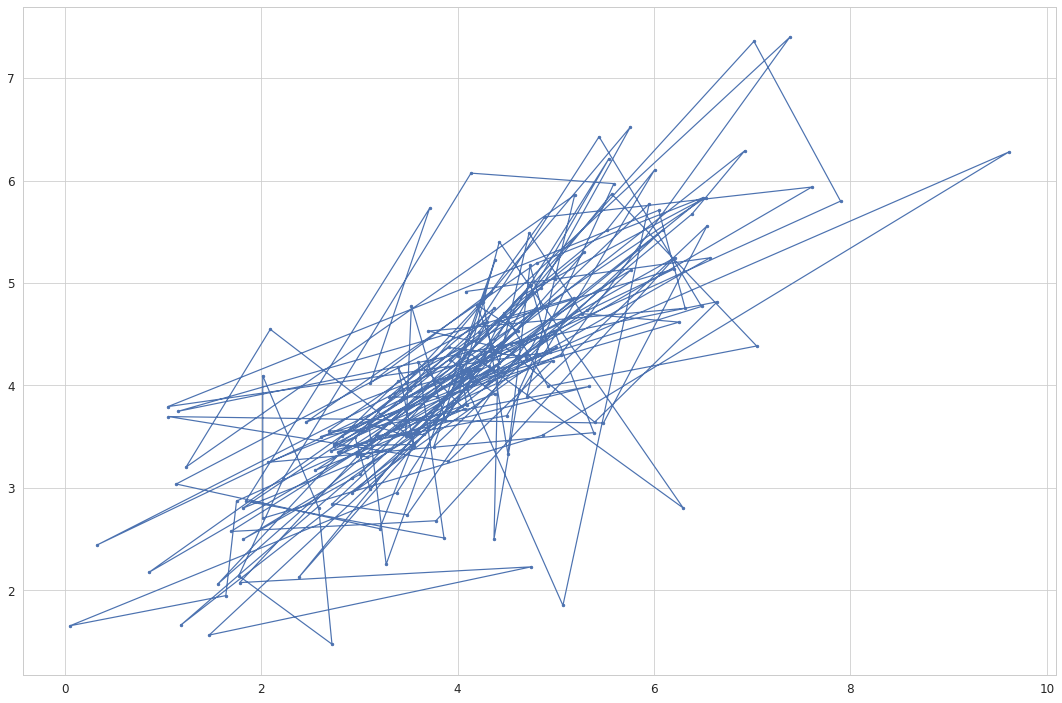

In [44]:
# con los datos de prueba
y_pred = model_2.predict(X_test)
graph_coef(y_test, y_pred, "model_2_coef")

El coeficiente de predicción es: [[0.58132414]]
Guardando figura model_2_coef_train


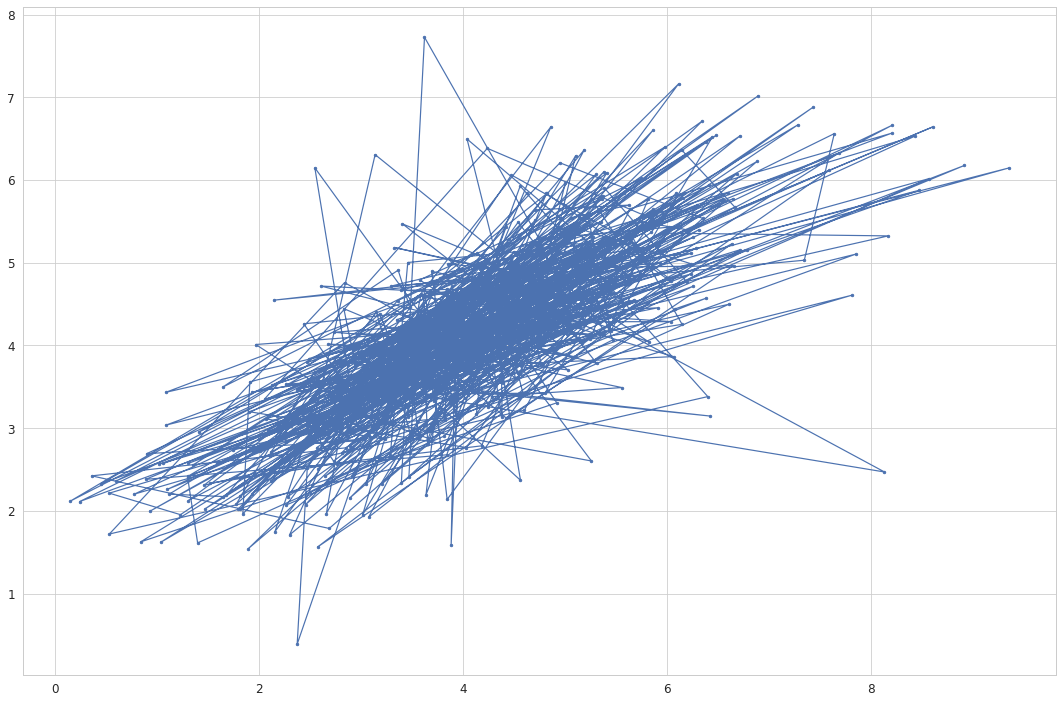

In [45]:
# predicción de los datos de entrenamiento
y_pred = model_2.predict(X_train)
graph_coef(y_train, y_pred, "model_2_coef_train")


**Arquitectura 3: 2 capas intermedias, 128 neuronas**

6 neuronas en la capa de entrada 128 neuronas en las capa oculta 1, 32 neuronas en la capa oculta 2, junto con la función de activación utilizada es SELU también 1 neurona en la salida.

In [46]:
def get_model_3():
    model = keras.models.Sequential([
        keras.layers.Dense(128, activation="selu", input_shape=[INPUT_DIM],kernel_initializer="lecun_normal"),
        keras.layers.Dense(32, activation="selu",kernel_initializer="lecun_normal"),
        keras.layers.Dense(NUM_CLASSES, activation="linear")
    ])
    return model

_Hiperparámetros:_

| Hiperparámetro | Descripción                                                       | Valor              |
| :------------: | ----------------------------------------------------------------- | ------------------ |
|    `epochs`    | Número de iteraciones sobre el conjunto de datos de entrenamiento | 20000                |
|  `batch_size`  | Número de muestras por gradiente                                  | 32                 |
|  `optimizer`   | Algoritmo de optimización                                         | Adamax Optimization |
|     `loss`     | Función de pérdida                                                | MSE                |
|   `metrics`    | Métrica de evaluación                                             | MSE, MAE           |

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 128)               896       
                                                                 
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


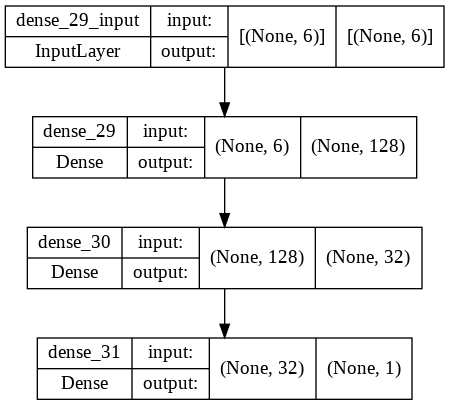

In [78]:
# Hiperparámetros Para el Modelo 1
# Utilizando el optimizador AdaGrad
adamax_optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Utilizando la función de pérdida MSE
mse_loss = keras.losses.MeanSquaredError()

# Utilizando la métrica MAE
mae_metric = keras.metrics.MeanAbsoluteError()

# Utilizando la métrica MSE
mse_metric = keras.metrics.MeanSquaredError()

# Utilizando el callback EarlyStopping y tensorboard
# early_stopping_cb = keras.callbacks.EarlyStopping(patience=1000, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Compilando el modelo
model_3 = get_model_3()
model_3.compile(
    loss=mse_loss, 
    optimizer=adamax_optimizer,
    metrics=[mae_metric, mse_metric]
)

# mostrando el resumen del modelo
# guardando el esquema del modelo en un archivo
model_3.summary()
plot_model(model_3, to_file=os.path.join(IMAGES_PATH,'model_3.png'), show_shapes=True, show_layer_names=True)

In [79]:
# Entrenar el modelo
history = model_3.fit(
    X_train, 
    y_train,
    epochs=20000,
    callbacks=[tensorboard_cb],
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=0
)

**Graficar la función de pérdida**

Guardando figura model_3_loss


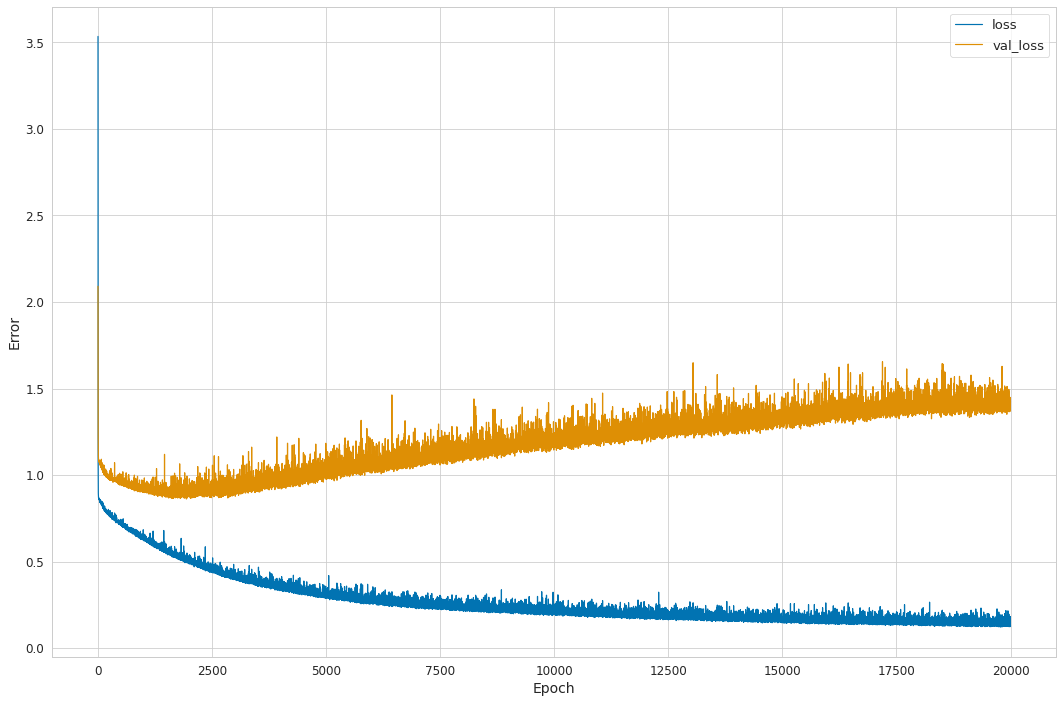

In [80]:
graph_loss(history, "model_3_loss")

**Evaluar el modelo**

In [81]:
evaluate_model(model_3, X_test, y_test)

El error cuadrado medio es: 1.4215673838501681
El error absoluto medio es: 0.8351588679774777
El coeficiente de determinación es: 0.41244823305048395
Score: [1.421567440032959, 0.8351588845252991, 1.421567440032959]


**Grafica de Valores Reales vs Predicciones**

Guardando figura model_3_real_vs_pred


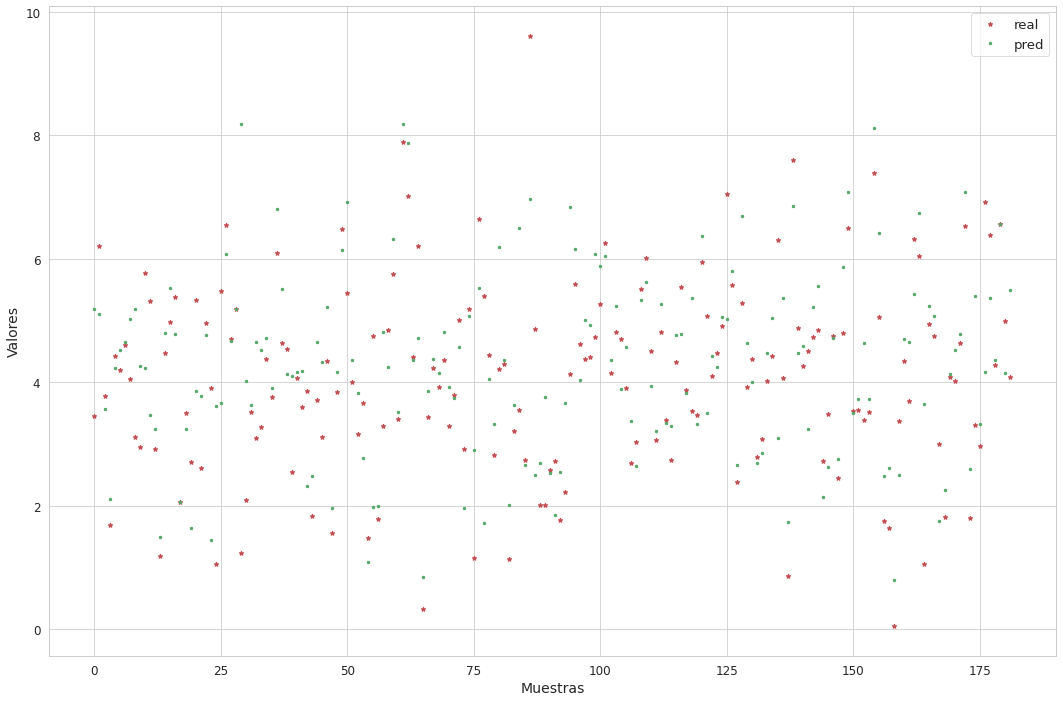

In [82]:
y_pred = model_3.predict(X_test)
graph_real_vs_pred(y_test, y_pred, "model_3_real_vs_pred")

Guardando figura model_3_real_vs_pred_train


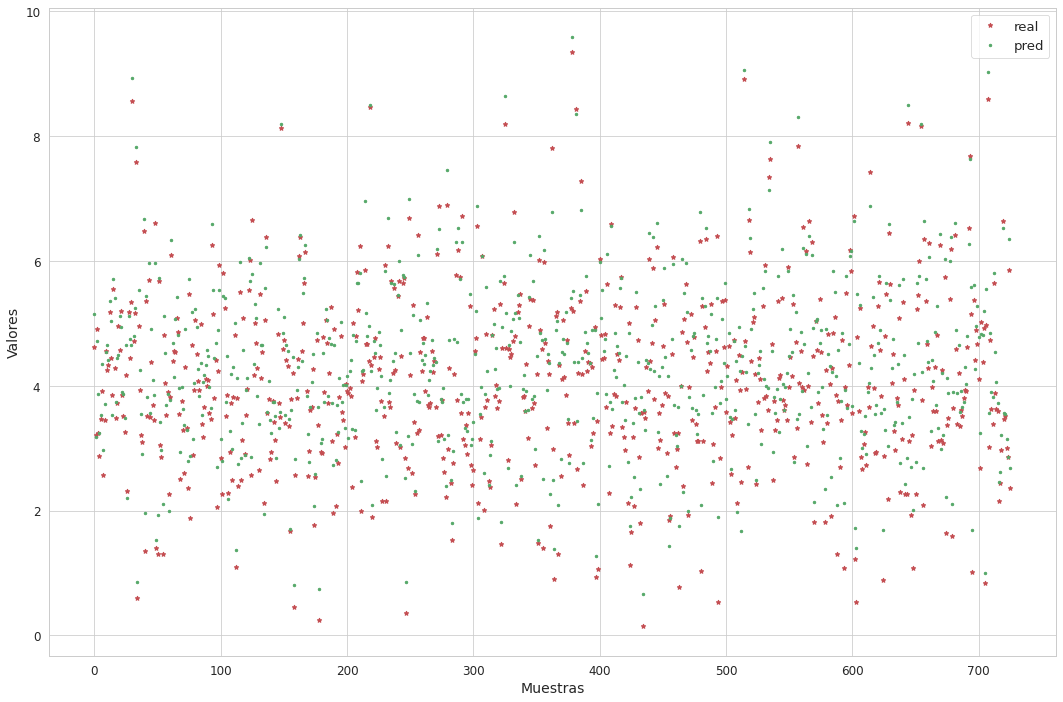

In [83]:
# con los datos de entrenamiento
y_pred = model_3.predict(X_train)
graph_real_vs_pred(y_train, y_pred, "model_3_real_vs_pred_train")

**Coeficiente de Regresión**

El coeficiente de predicción es: [[0.67157633]]
Guardando figura model_3_coef


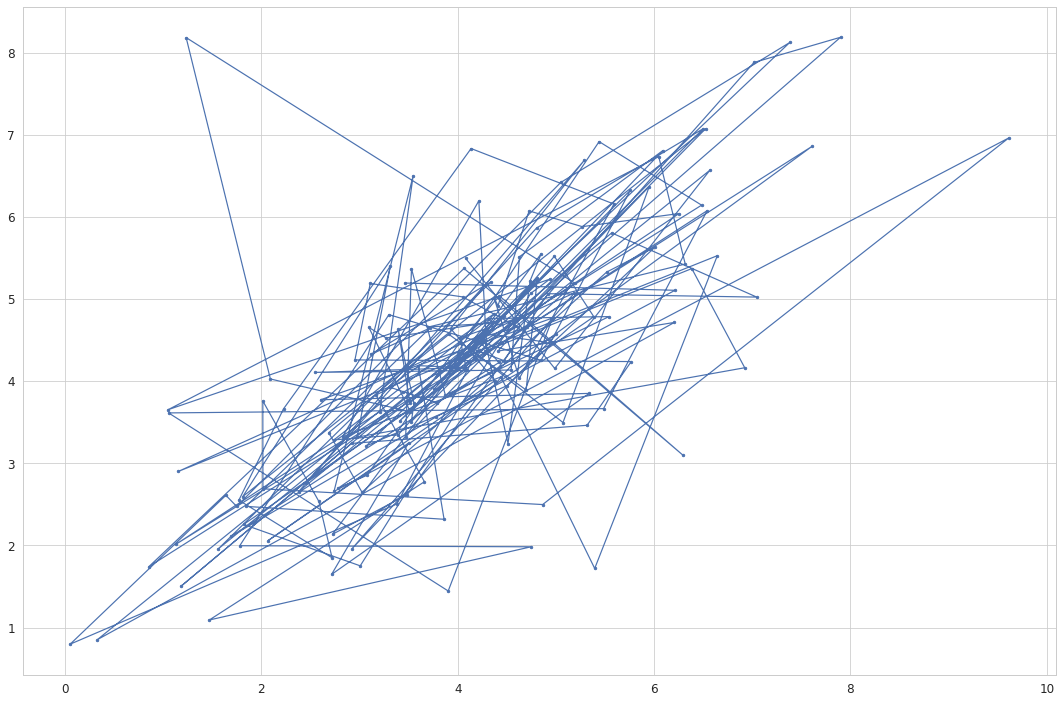

In [84]:
# con los datos de prueba
y_pred = model_3.predict(X_test)
graph_coef(y_test, y_pred, "model_3_coef")

El coeficiente de predicción es: [[0.91531639]]
Guardando figura model_3_coef_train


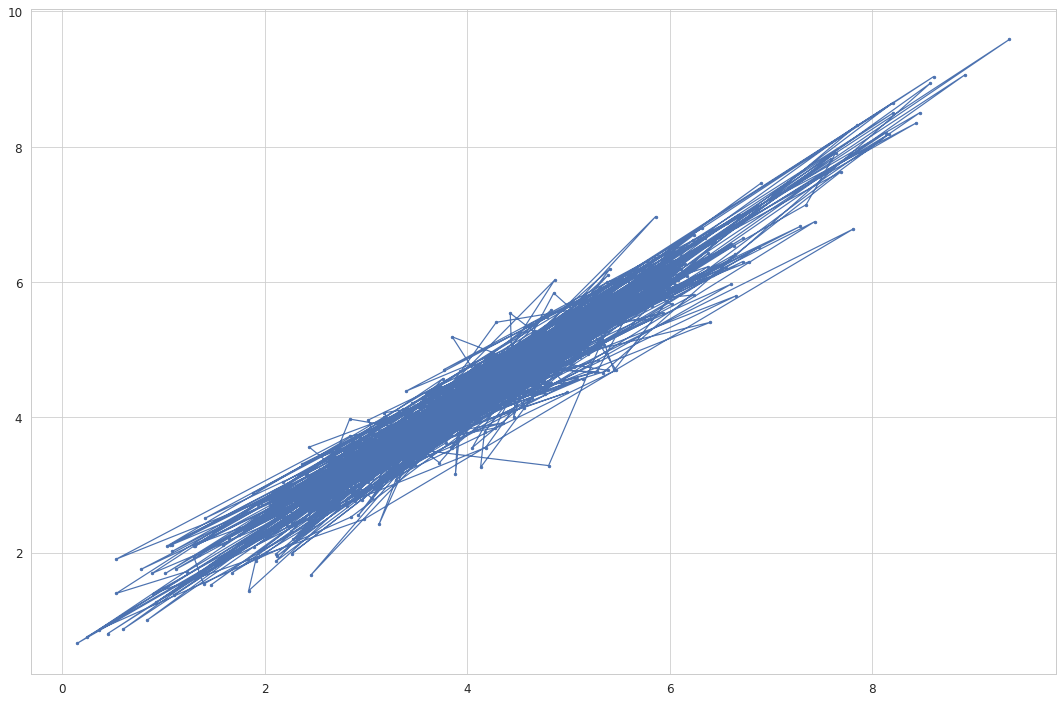

In [85]:
# predicción de los datos de entrenamiento
y_pred = model_3.predict(X_train)
graph_coef(y_train, y_pred, "model_3_coef_train")


**Arquitectura 3 Con early Stopping**

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 128)               896       
                                                                 
 dense_33 (Dense)            (None, 32)                4128      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 5,057
Trainable params: 5,057
Non-trainable params: 0
_________________________________________________________________


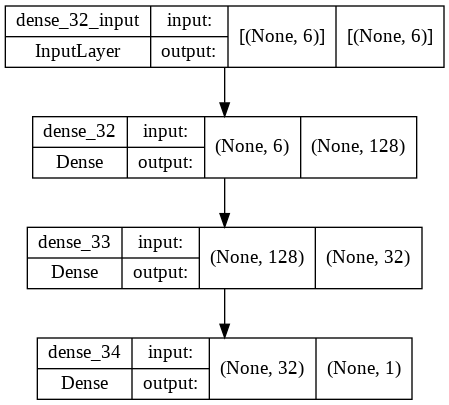

In [86]:
# Hiperparámetros Para el Modelo 1
# Utilizando el optimizador AdaGrad
adamax_optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# Utilizando la función de pérdida MSE
mse_loss = keras.losses.MeanSquaredError()

# Utilizando la métrica MAE
mae_metric = keras.metrics.MeanAbsoluteError()

# Utilizando la métrica MSE
mse_metric = keras.metrics.MeanSquaredError()

# Utilizando el callback EarlyStopping y tensorboard
early_stopping_cb = keras.callbacks.EarlyStopping(patience=700, restore_best_weights=True)
tensorboard_cb = keras.callbacks.TensorBoard(get_run_logdir())

# Compilando el modelo
model_3_es = get_model_3()
model_3_es.compile(
    loss=mse_loss, 
    optimizer=adamax_optimizer,
    metrics=[mae_metric, mse_metric]
)

# mostrando el resumen del modelo
# guardando el esquema del modelo en un archivo
model_3_es.summary()
plot_model(model_3_es, to_file=os.path.join(IMAGES_PATH,'model_3_es.png'), show_shapes=True, show_layer_names=True)

In [87]:
# Entrenar el modelo
history = model_3_es.fit(
    X_train, 
    y_train,
    epochs=20000,
    callbacks=[tensorboard_cb,early_stopping_cb],
    validation_data=(X_test, y_test),
    batch_size=32,
    verbose=0
)

**Graficar la función de pérdida**

Guardando figura model_3_es_loss


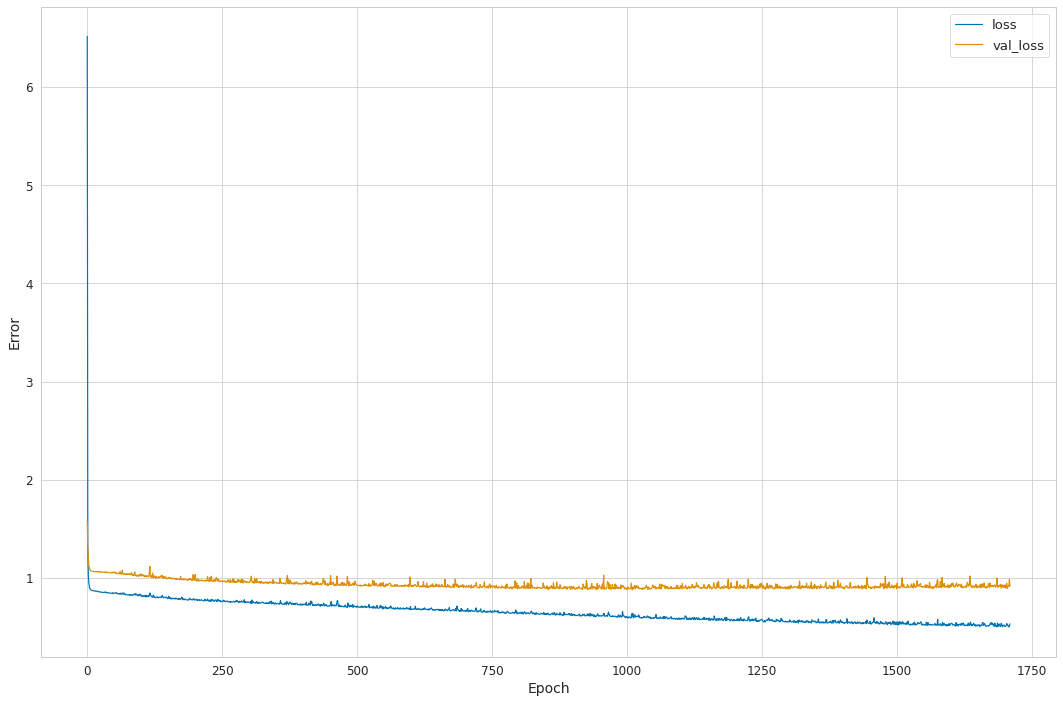

In [88]:
graph_loss(history, "model_3_es_loss")

**Evaluar el Modelo**

In [90]:
evaluate_model(model_3_es, X_test, y_test)

El error cuadrado medio es: 0.8799127569152951
El error absoluto medio es: 0.6651338360073802
El coeficiente de determinación es: 0.6363209363408605
Score: [0.8799128532409668, 0.6651338338851929, 0.8799128532409668]


**Grafica de Valores Reales vs Predicciones**

Guardando figura model_3_es_real_vs_pred


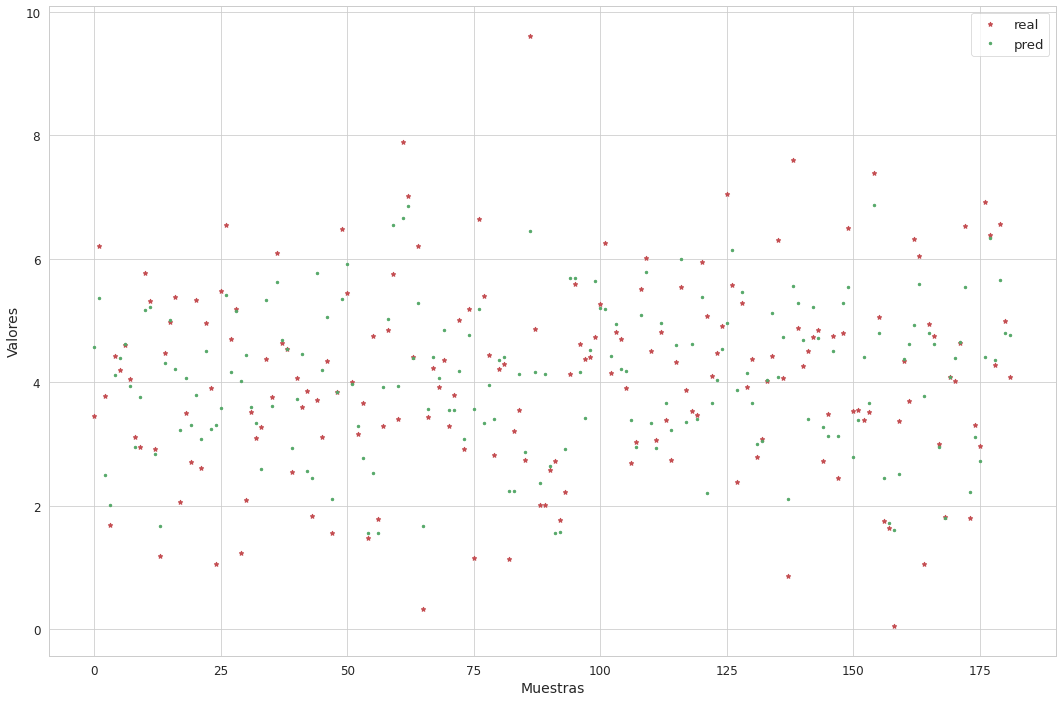

In [91]:
y_pred = model_3_es.predict(X_test)
graph_real_vs_pred(y_test, y_pred, "model_3_es_real_vs_pred")

Guardando figura model_3_es_real_vs_pred_train


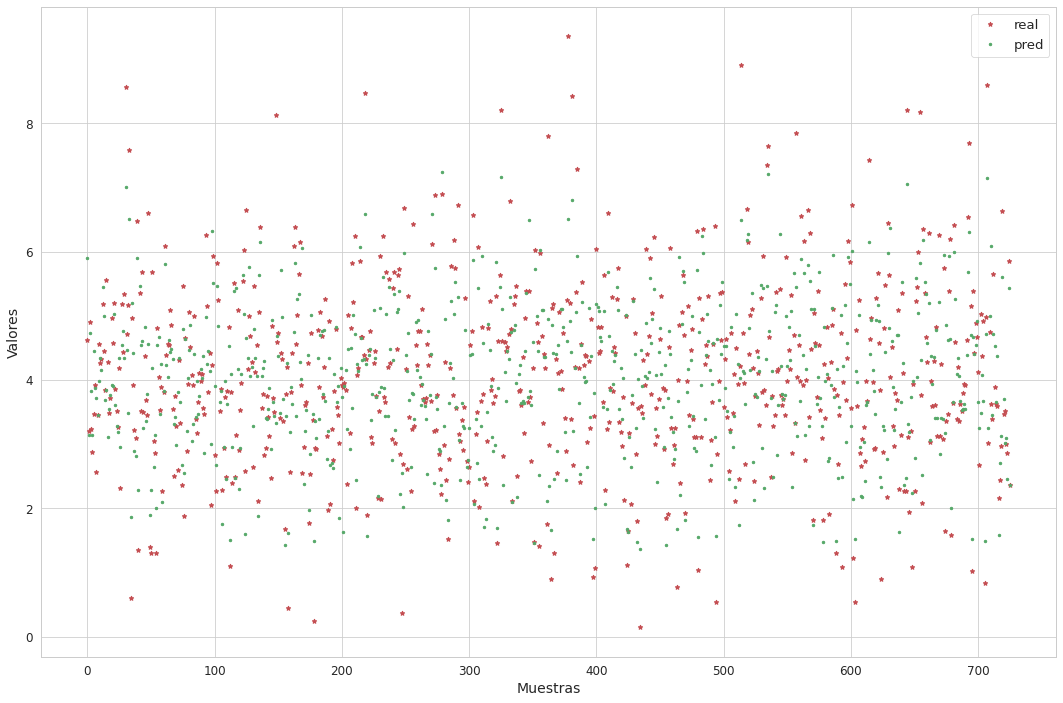

In [92]:
# con los datos de entrenamiento
y_pred = model_3_es.predict(X_train)
graph_real_vs_pred(y_train, y_pred, "model_3_es_real_vs_pred_train")

**Coeficiente de Regresión**

El coeficiente de predicción es: [[0.60715573]]
Guardando figura model_3_es_coef


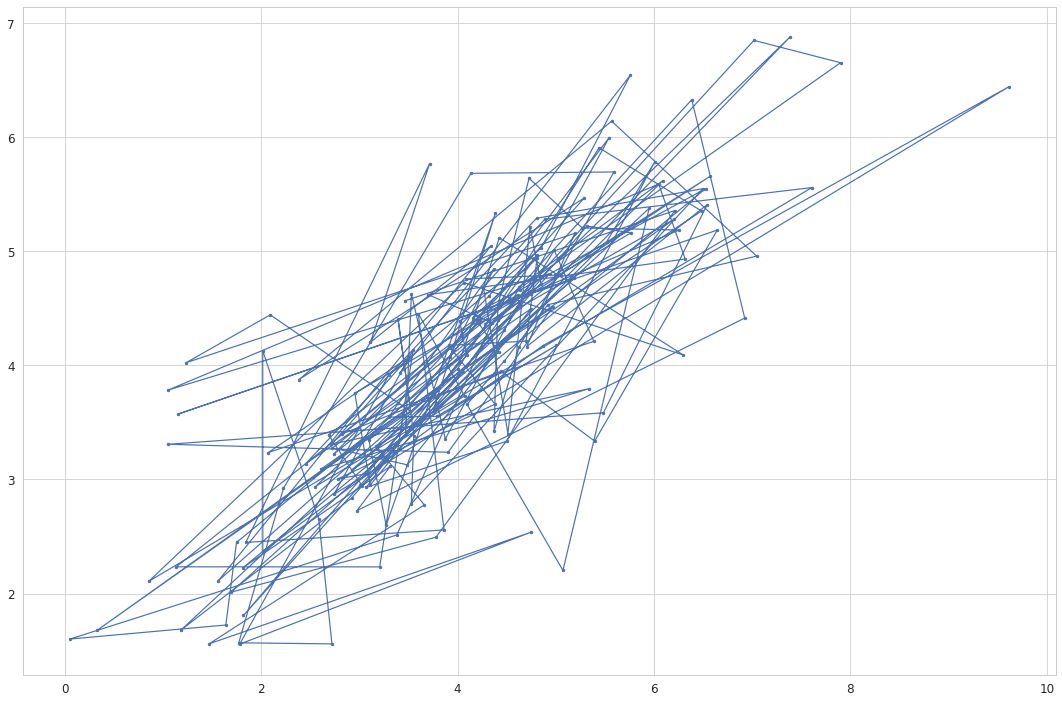

In [93]:
# con los datos de prueba
y_pred = model_3_es.predict(X_test)
graph_coef(y_test, y_pred, "model_3_es_coef")

El coeficiente de predicción es: [[0.68671031]]
Guardando figura model_3_es_coef_train


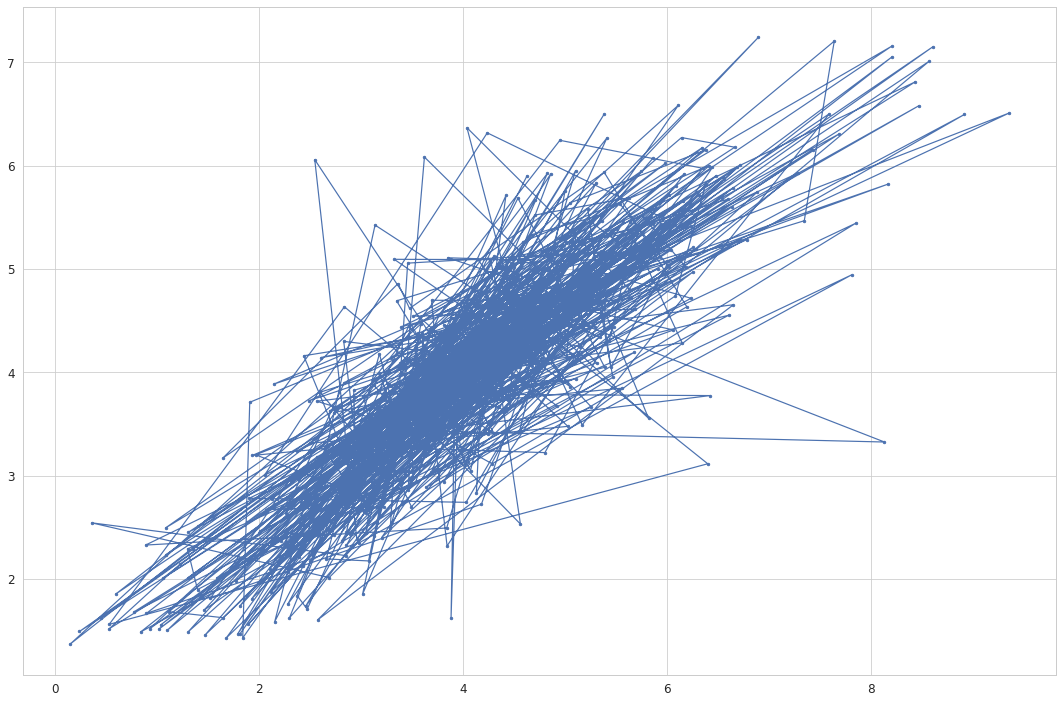

In [94]:
# predicción de los datos de entrenamiento
y_pred = model_3_es.predict(X_train)
graph_coef(y_train, y_pred, "model_3_es_coef_train")

#### Guardar Modelos

In [98]:
save_model(model_1,"model_1")
save_model(model_2,"model_2")
save_model(model_3,"model_3")
save_model(model_3_es,"model_3_es")

#### Extraer los Pesos de la Red Neuronal Entrenada

In [115]:
save_weights(model_1,"model_1")
save_weights(model_2,"model_2")
save_weights(model_3,"model_3")
save_weights(model_3_es,"model_3_es")

### Conclusión

1. La arquitectura que mejor se ha comportado es la **tercera**, primeramente teniendo menos parámetros que la arquitectura dos, siendo esto positivo para correrlo en arduino y logrando mejores resultados que el mismo. Para el caso de la arquitectura uno, por ser más sencilla, obtiene menores resultados.

2. **Importancia del Early Stopping:** Para el caso específico de la arquitectura 3 se notó que al correr 20000 épocas, se logró un coeficiente de regresión de `0.67`, no obstante, al implementar un early stopping de 700 épocas, se logra apreciar que el error cuadrado medio es de `0.88` siendo menor al otro que obtuvo una valoración de `1.42`, es por ello que aunque el coeficiente de regresión este más lejos del valor ideal (uno) el rango de error que comprende la valoración es menor, y es un punto a favor en al toma de decisiones en algo tan importante como lo es la determinación de la toxicidad en los pescados.

3. **Features más importantes:** Al implementar el feature importance se logró notar que ciertos features tienen más peso para la valoración de la toxicidad. Realizar la técnica de feature importance es necesario para lograr la comprensión más allá de los datos y lograr una mejor interpretación del modelo.

4. **Prueba y Error**: Para lograr un mejor comportamiento del modelo de regresión el proceso consistió en probar repetidamente las arquitecturas con el propósito de optimizarlas, es por ello que nunca puede faltar la optimización de hiperparámetros para mejorar las métricas del modelo. También la documentación fué pilar fundamental en el desarrollo de este proyecto.